In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [178]:
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv('/content/drive/MyDrive/imdb_top_1000.csv')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [180]:
data.shape

(1000, 16)

In [181]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
IMDB_Rating,1000.0,7.94930,0.275491,7.6,7.70,7.9,8.10,9.3
Meta_score,843.0,77.97153,12.376099,28.0,70.00,79.0,87.00,100.0
No_of_Votes,1000.0,273692.91100,327372.703934,25088.0,55526.25,138548.5,374161.25,2343110.0


In [182]:
data.isnull().sum()

Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [183]:
data['Meta_score'].fillna(data['Meta_score'].mean(), inplace=True)
data.isnull().sum()

Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score         0
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

<Axes: xlabel='IMDB_Rating', ylabel='Count'>

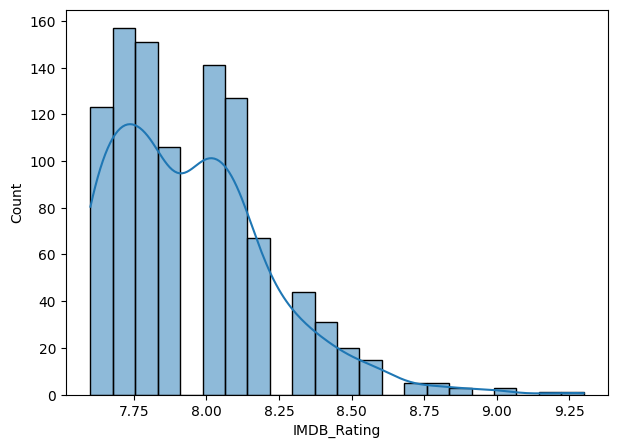

In [184]:
plt.figure(figsize=(7,5))
sns.histplot(data['IMDB_Rating'],kde=True)

In [185]:
highdata = data['Meta_score'].value_counts().index[0]

# izračunati međukvartilno rastojanje
q1, q3 = np.percentile(data['No_of_Votes'], [25, 75])
iqr = q3 - q1

# pronalazenje vrednosti
outliers = data[data['No_of_Votes'] < q1 - 1.5 * iqr]
outliers = data[data['No_of_Votes'] > q3 + 1.5 * iqr]


# en bacite visoku vrednost u drugi okvir podataka
Data = data[data['Meta_score'] != highdata]
NewData=outliers

In [186]:
NewData=pd.DataFrame(NewData[['IMDB_Rating','No_of_Votes','Meta_score']])

In [187]:
y=NewData['IMDB_Rating'].values
x=NewData.drop('IMDB_Rating',axis=1).values

In [188]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=15)

In [189]:
scaler=StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [190]:
model=Sequential()
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='relu'))

model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

In [191]:
earlyStopping=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

**CPU**

In [192]:
model.fit(x=x_train,y=y_train,epochs=300,validation_data=(x_test,y_test),verbose=1,callbacks=[earlyStopping])

Epoch 1/300
2/2 [==============================] - 1s 202ms/step - loss: 80.1732 - val_loss: 69.2309
Epoch 2/300
2/2 [==============================] - 0s 32ms/step - loss: 76.4193 - val_loss: 67.5329
Epoch 3/300
2/2 [==============================] - 0s 35ms/step - loss: 72.1736 - val_loss: 66.2106
Epoch 4/300
2/2 [==============================] - 0s 33ms/step - loss: 70.4941 - val_loss: 64.9506
Epoch 5/300
2/2 [==============================] - 0s 34ms/step - loss: 68.1924 - val_loss: 63.6639
Epoch 6/300
2/2 [==============================] - 0s 36ms/step - loss: 65.9732 - val_loss: 62.2875
Epoch 7/300
2/2 [==============================] - 0s 31ms/step - loss: 64.2404 - val_loss: 60.7417
Epoch 8/300
2/2 [==============================] - 0s 33ms/step - loss: 62.0247 - val_loss: 59.0108
Epoch 9/300
2/2 [==============================] - 0s 33ms/step - loss: 59.5288 - val_loss: 57.0322
Epoch 10/300
2/2 [==============================] - 0s 32ms/step - loss: 58.3610 - val_loss: 54.752

**CPU**

<Axes: >

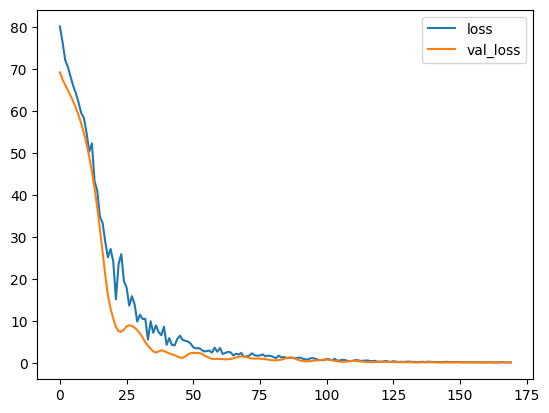

In [193]:
modellost=pd.DataFrame(model.history.history)
modellost.plot()

**`TPU`**



In [194]:
predictionSequence=model.predict(x_test)
mean_absolute_error(y_test,predictionSequence)

1/1 [==============================] - 0s 123ms/step


0.23742225481116264

In [195]:
df = pd.DataFrame({
    'Predvidjanja': predictionSequence.flatten(),
    'Stvarne vrednosti': y_test.flatten()
})

df.head(10)

,Predvidjanja,Stvarne vrednosti
0,8.311060,8.6
1,8.449284,8.4
2,8.257633,8.3
3,8.252054,7.9
4,8.294582,8.5
5,8.294923,8.3
6,8.320133,7.8
7,8.259875,8.1
8,8.275210,8.3
9,8.282473,8.1
